In [1]:
# !echo "rdr pass inet proto tcp from any to any port 80 -> 166.216.165.114 port 49172" | sudo pfctl -ef -

http://apple.stackexchange.com/questions/230300/what-is-the-modern-way-to-do-port-forwarding-on-el-capitan-forward-port-80-to/230331#230331

In [2]:
# echo "
# rdr pass inet proto tcp from any to any port 80 -> 127.0.0.1 port 8080
# " | sudo pfctl -ef -

```
echo "
rdr pass inet proto tcp from any to any port 80 -> 127.0.0.1 port 8080
" | sudo pfctl -ef -
```

__NOTES__

- Ultraorthodox (Haredi) communities are prohibited from using social media, unlikely to have new members or interaction with wider community (not good in term of a market for Hebrew learners).
- 

In [3]:
from probplots import plot_dists_pps

from collections import OrderedDict
from imp import reload
import pdb
import random

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.display import SVG, display

from hud_geo_conversions import read_zips_to_fips
from map_maker import draw_county_data_svg
from utilities import (display_cb, is_outlier_instance, is_outlier_val,
                       boxcox_standardize, read_fips_codes)
from probplots import ProbPlots, plot_dists_pps



from ajpp import read_ajpp_geo, read_ajpp_pop
import jdata
from jewish_county_data import read_jdata_counties, clean_jdata_county
from acs import read_acs_israeli_ancestry
from religion_census import read_all_denoms, read_cb, read_judaic_denoms




pd.set_option('display.float_format', lambda x: '%.3f' % x)
from sklearn.decomposition import PCA

%matplotlib inline

SEED = 42
random.seed(SEED)

In [4]:
DATA_DIR    = '../Data/'
IMG_DIR = '../Images/'
COLORED_DIR = ''.join([IMG_DIR, 'colored.svg'])  # for playing around
DEM_DIR = ''.join([DATA_DIR, 'Demography/'])
SCL_DIR = ''.join([DATA_DIR, 'Schools/'])

ZIPS_TO_FIPS_FP = ''.join([DATA_DIR, 'ZIP_COUNTY_122016.xlsx'])


zips_to_fips = read_zips_to_fips()  # used for multiple datasets later
fips_codes = read_fips_codes(''.join([DATA_DIR, 'Census-2010-County-FIPS.txt']))



B01003_FP = ''.join([DEM_DIR, 'ACS_15_5YR_B01003.csv'])
B04004_FP = ''.join([DEM_DIR, 'ACS_15_5YR_B04004.csv'])
B04005_FP = ''.join([DEM_DIR, 'ACS_15_5YR_B04005.csv'])

REL_DIR  = ''.join([DATA_DIR, 'Religion/'])
RELCEN_CB_FP  = ''.join([REL_DIR, 'US-Religion-Census-2010-County-File-CB.TXT'])
RELCEN_FP = ''.join([REL_DIR, 'US-Religion-Census-2010-County-File.DTA'])

JDATA_FP = ''.join([SCL_DIR, 'jdata_directory.json'])

AJPP_FP      = ''.join([DEM_DIR, 'AJPP_County2015.xlsx'])
AJPP_GEO_FP  = ''.join([DEM_DIR, 'AJPP_CountyGroupDefinitions2015.xlsx'])

## Merge Tables

Choosing to use counties instead of zips because zips are more likely to conflate same areas

Scaling methodology

- Try LDA, Factor Analysis

In [5]:
from jewish_county_data import read_jdata_counties

In [6]:
acs = read_acs_israeli_ancestry(B01003_FP, B04004_FP, B04005_FP,
                                drop_counties=True)
relcen = read_judaic_denoms(RELCEN_FP)

In [7]:
jd_cnty = (read_jdata_counties(JDATA_FP, ZIPS_TO_FIPS_FP, how='all')
           .pipe(clean_jdata_county)
          )

In [8]:
counties = pd.concat([jd_cnty, relcen, acs], axis=1)
counties = (counties.drop(['County', 'State'], axis=1)
            .select(lambda x: not ('Tot' in x or '_Pc' in x), axis=1)
            .fillna(0)
           )


# counties = (counties.drop(['UnionMessJews_Cngs'], axis=1)
#             .assign(
#                 Total_Israeli=(counties.Part_Israeli_No +
#                                counties.Only_Israeli_No))
#             .drop(['Part_Israeli_No', 'Only_Israeli_No'], axis=1))

# counties = np.log(counties+1)

In [9]:
((counties==0).sum()/len(counties)).sort_values()

Type_Part_time_school         0.705
Type_Early_childhood_center   0.852
Denom_Reform                  0.852
Denom_Orthodox                0.880
Denom_Conservative            0.892
RefJud_Ra                     0.896
RefJud_No                     0.896
RefJud_Cngs                   0.898
Type_Day_school               0.912
Only_Israeli_No               0.933
Part_Israeli_No               0.933
ConsvJud_Ra                   0.946
ConsvJud_No                   0.946
ConsvJud_Cngs                 0.948
OrthJudCngs                   0.950
OrthJud_No                    0.951
OrthJud_Ra                    0.951
Denom_Community               0.956
Denom_Pluralist_Transdenom    0.969
Denom_Other                   0.974
ReconJud_No                   0.983
ReconJud_Ra                   0.983
ReconJud_Cngs                 0.983
Denom_Reconstructionist       0.984
UnionMessJews_Cngs            0.987
Denom_Secular                 0.995
dtype: float64

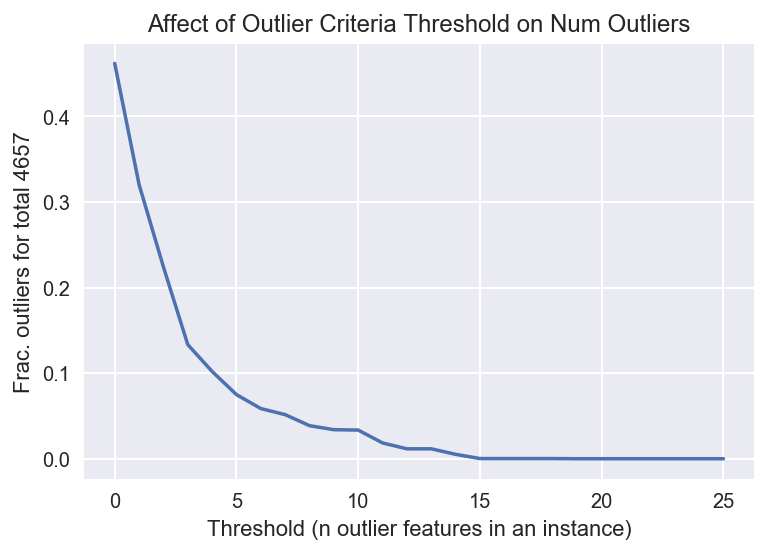

In [10]:
threshs = list(range(1, counties.shape[1]+1))
non_outls = [len(counties[is_outlier_instance(counties, thresh)])
             for thresh in threshs]

plt.plot([n/len(counties) for n in non_outls])
plt.xlabel('Threshold (n outlier features in an instance)')
plt.ylabel('Frac. outliers for total {}'.format(len(counties)))
plt.title('Affect of Outlier Criteria Threshold on Num Outliers');

In [11]:
jd_cnty.head()

,Type_Day_school,Type_Early_childhood_center,Type_Part_time_school,Denom_Community,Denom_Conservative,Denom_Orthodox,Denom_Other,Denom_Pluralist_Transdenom,Denom_Reconstructionist,Denom_Reform,Denom_Secular
FIPS,,,,,,,,,,,
01002,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
01040,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
01060,1.000,1.000,2.000,1.000,2.000,0.000,0.000,0.000,0.000,1.000,0.000
01106,2.000,1.000,1.000,1.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000
01108,0.000,1.200,2.400,0.000,1.200,0.000,0.000,0.000,0.000,1.200,0.000


In [12]:
COLS = ['Type_Day_school', 'Type_Early_childhood_center',
        'Type_Part_time_school',
        
        'Denom_Other', 'Denom_Pluralist_Transdenom', 'Denom_Secular',
        'Denom_Community',
        
        'Denom_Reconstructionist', 'ReconJud_Cngs', 'ReconJud_No',
        'Denom_Reform', 'RefJud_Cngs', 'RefJud_No',
        'Denom_Conservative', 'ConsvJud_Cngs', 'ConsvJud_No',
        'Denom_Orthodox', 'OrthJudCngs', 'OrthJud_No',
        'UnionMessJews_Cngs', 
        
        'Only_Israeli_No', 'Part_Israeli_No']

counties = counties[COLS]
counties = counties.select(lambda x: '_No' not in x or
                           x in ['Only_Israeli_No', 'Part_Israeli_No'],
                           axis=1)

In [13]:
from sklearn.decomposition import TruncatedSVD

# data = np.log(counties+1)
# data = boxcox_standardize(counties)
# counties

from sklearn.preprocessing import MinMaxScaler
cnty = pd.DataFrame(
    MinMaxScaler().fit_transform(np.log(counties+1)),
    columns=counties.columns, index=counties.index)
cnty = np.log(counties+1)
# data = boxcox_standardize(counties)

reducer = PCA(n_components=10).fit(cnty)
reducer.explained_variance_ratio_.tolist()

[0.7292952152041253,
 0.11323534202144021,
 0.04235632050845317,
 0.023245321942568065,
 0.021402234191926463,
 0.01448414921057129,
 0.010532480307955764,
 0.009366018019242566,
 0.00852616746062685,
 0.007881069275589264]

In [14]:
# pd.DataFrame(data, columns=cnty.columns).describe().T

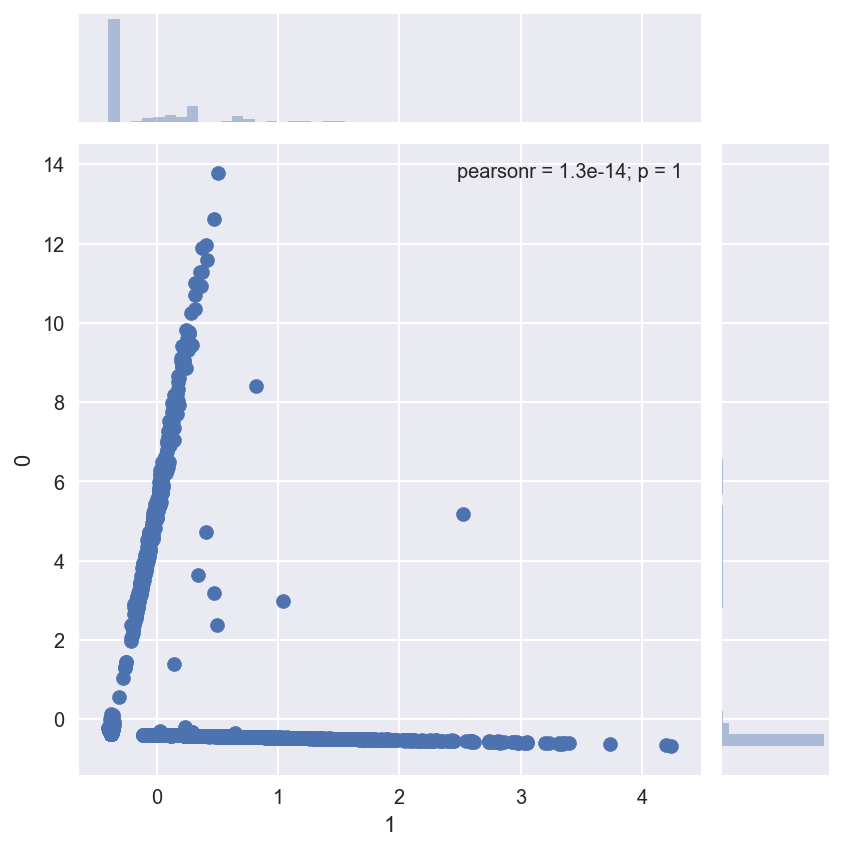

In [15]:
reduced = reducer.transform(cnty)
reduced = pd.DataFrame(reduced)
sns.jointplot(x=1, y=0, data=reduced)

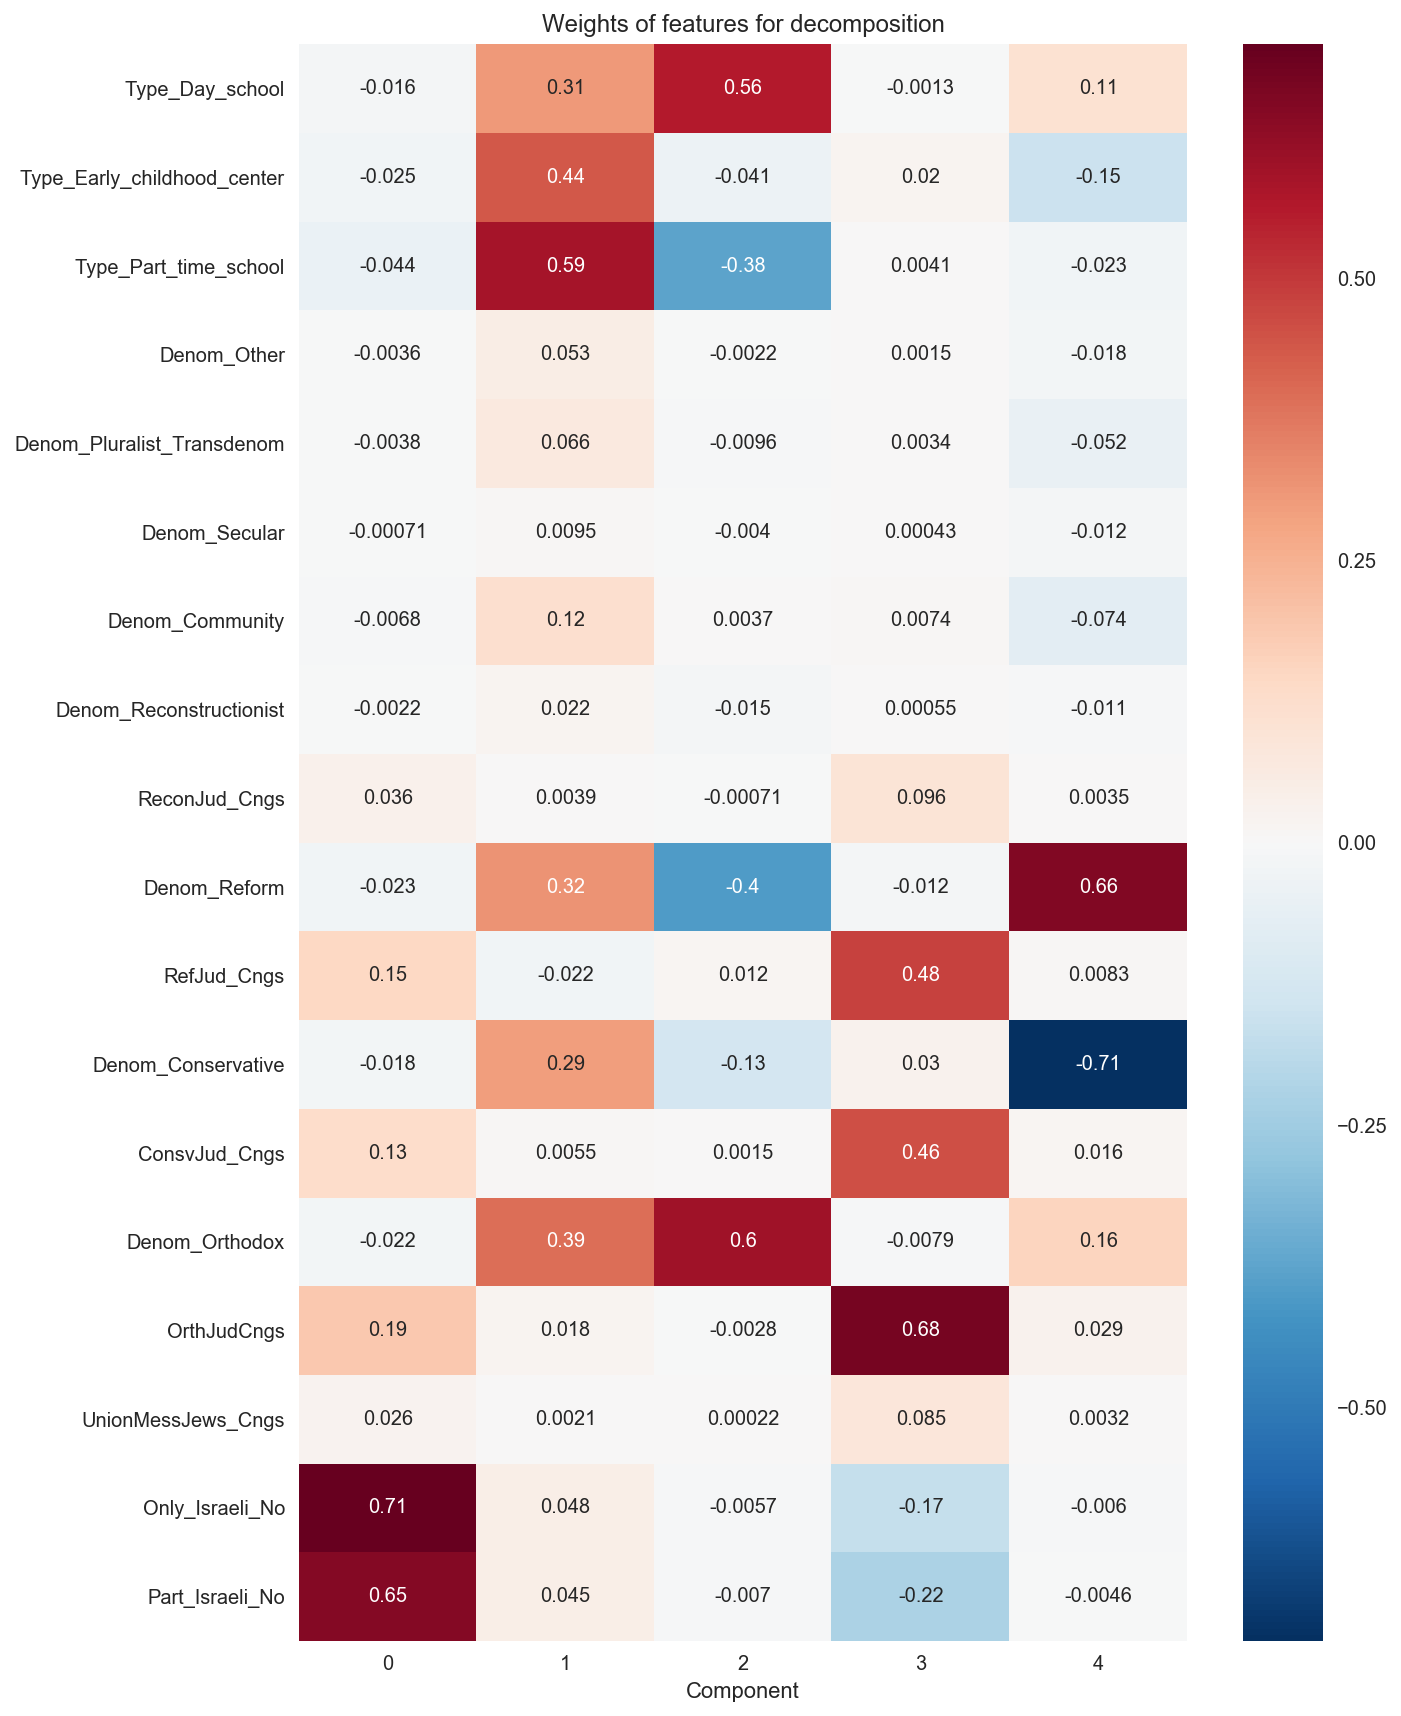

In [16]:
comps = pd.DataFrame(reducer.components_[:5, :], columns=cnty.columns)
plt.figure(figsize=(10, 12))
sns.heatmap(comps.T, annot=True)

plt.title('Weights of features for decomposition')
plt.xlabel('Component')

plt.tight_layout();

In [17]:
import hdbscan

In [18]:
clust = hdbscan.HDBSCAN(min_cluster_size=5).fit(cnty)

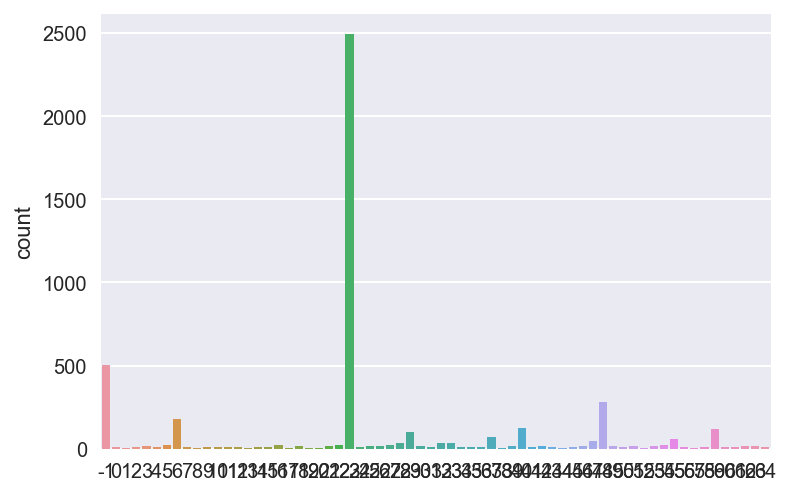

In [19]:
sns.countplot(clust.labels_)

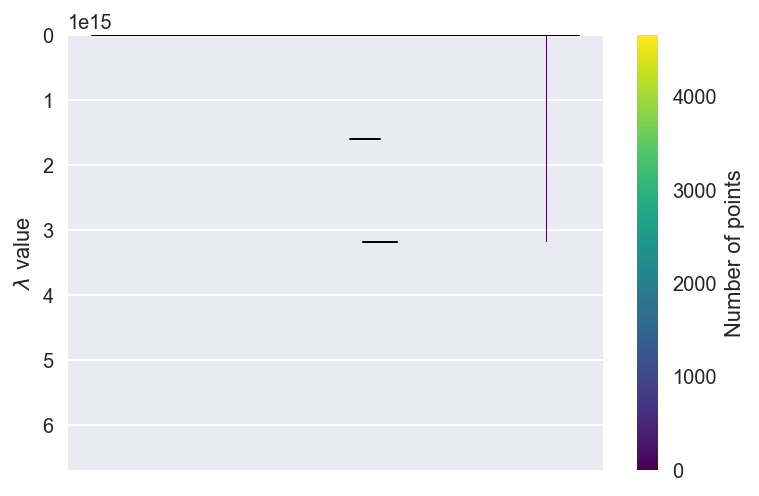

In [20]:
clust.condensed_tree_.plot(log_size=False, label_clusters=True)
# plt.ylim(300, 0)

In [21]:
clust.single_linkage_tree_.plot()

RecursionError: maximum recursion depth exceeded while getting the str of an object

In [ ]:
df = clust.single_linkage_tree_.to_pandas()

In [ ]:
data = pd.DataFrame(reducer.transform(cnty)[:, :4]).assign(cluster=clust.labels_)

plt.figure(figsize=(5, 5))
sns.pairplot(data=data[data.cluster>-1], hue='cluster');

In [ ]:
from sklearn.metrics import silhouette_score

data = cnty[clust.labels_>-1]
preds = clust.labels_[clust.labels_>-1]
silhouette_score(data, preds)

In [ ]:
DIR = ''.join([IMG_DIR, 'play'])
colors = list(sns.color_palette('husl', len(np.unique(clust.labels_))).as_hex())
draw_county_data_svg(pd.Series(clust.labels_+1, index=cnty.index, name='clust'), DIR,
                     colors=colors, zero_color='#bebebe')

SVG(DIR)

In [ ]:
data = cnty.assign(cluster=clust.labels_)
sns.pointplot(x='cluster', y='Denom_Reform', data=data)

In [ ]:
ajpp_county = read_ajpp_county(AJPP_FP, AJPP_GEO_FP)

In [ ]:
data = (pd.DataFrame(clust.labels_, index=cnty.index, columns=['clust'])
        .join(ajpp_county))

sns.boxplot(x='clust', y='Jewish_By_Rel', data=data)
plt.semilogy();

In [ ]:
data = (pd.DataFrame(clust.labels_, index=cnty.index, columns=['clust'])
        .join(urb_rur))

sns.boxplot(x='clust', y='POPPCT_URBAN', data=data)

In [ ]:
data.groupby('pred').mean()

In [ ]:
data = cnty.assign(cluster=clust.labels_).groupby('cluster').count()
data

In [ ]:
data = (data
        .assign(cluster=clust.labels_).groupby('cluster').mean())
sns.heatmap(data=data)
plt.title('Compare Means of MinMaxScaled features.')

In [ ]:
data = (pd.DataFrame(MinMaxScaler().fit_transform(cnty),
                     columns=cnty.columns)
        .assign(cluster=clust.labels_).groupby('cluster').mean())
sns.heatmap(data=data)
plt.title('Compare Means of MinMaxScaled features.')

In [ ]:
from yellowbrick.features.rankd import Rank2D
from yellowbrick.features.radviz import RadViz
from yellowbrick.features.pcoords import ParallelCoordinates


visualizer = Rank2D(algorithm='covariance')

visualizer.fit(cnty)                # Fit the data to the visualizer
visualizer.transform(cnty)             # Transform the data
visualizer.poof();    # Draw/show/poof the data

In [ ]:
visualizer = ParallelCoordinates()

visualizer.fit(cnty.as_matrix(), np.random.randint(0, 5, 662))     # Fit the data to the visualizer
visualizer.transform(cnty)   # Transform the data
visualizer.poof()    ;     # Draw/show/poof the data

In [ ]:
rc_drop = ['County', 'State',
           'Tot_Cngs', 'Tot_No', 'Tot_Pc']

merged = (acs.join(urb_rur[['POPPCT_URBAN']])
          .join(jd_county, how='outer')
          .join(relcen.drop(rc_drop, axis=1), how='outer')
          .fillna(0))

In [ ]:
# dropping rows that are needed to be empty at first, i.e.
# drop_counties=False (default) for read_acs, because
# general population data is used for counties with only
# jdata org data
has_dat = (merged.loc[:, 'Only_Israeli_No':]!=0.).any(1)
merged = merged[has_dat]
merged.T.head()

In [ ]:
merged.shape, acs.shape, jd_county.shape, relcen.shape

In [ ]:
merged[stdrd_cols+cols].shape

In [ ]:
from sklearn.preprocessing import MinMaxScaler
x = merged[['Tot_Jews', 'Tot_JewCngs']]
scaled = pd.DataFrame(MinMaxScaler().fit_transform(x),
                      columns=['Tot_Jews_Sc', 'Tot_JewCngs_Sc'],
                      index=x.index)
x = pd.concat([x, scaled], axis=1)
# sns.pairplot(x, 

In [ ]:
stdrd_cols = ['Total_Pop']

cols = [
    'Only_Israeli_No',
    'Part_Israeli_No',
    'Tot_Israeli_No',
    'POPPCT_URBAN',
    
    'Denom_Conservative',
    'Denom_Orthodox',
    'Denom_Other',
    'Denom_Reconstructionist',
    'Denom_Reform',
    'Tot_Orgs',
    'ConsvJud_No',
    'OrthJud_No',
    'ReconJud_No',
    'RefJud_No',
    'UnionMessJews_Cngs',
    'Tot_Jews',
    'Tot_JewCngs',
    'Type_Day_school',
    'Type_Early_childhood_center',
    'Type_Part_time_school',]

sns.pairplot(merged[stdrd_cols+cols])

## Exploration

More info on SVGs:
http://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/IPython%20Kernel/Rich%20Output.ipynb
http://flowingdata.com/2009/11/12/how-to-make-a-us-county-thematic-map-using-free-tools/
https://github.com/jaeahlee/svg-map-counties.git

In [ ]:
dat_no = merged.select(lambda x: not x.endswith('_Pc'), axis=1)
dat_tots = merged.select(lambda x: x.startswith('Tot') or x in ['County', 'State'], axis=1)
dat_tots = merged.select(lambda x: x.startswith('Tot_') and not x.endswith('_Pc'), axis=1)
dat_tots.head()

In [ ]:
has_relcen = (dat_tots.Tot_JewCngs!=0) | (dat_tots.Tot_Jews!=0)
has_acs = dat_tots.Tot_Israeli_No!=0
has_jdata = dat_tots.Tot_Orgs!=0

mer_has_dat = pd.DataFrame(dict(Congregants=has_relcen,
                                Israeli=has_acs,
                                Orgs=has_jdata))
n_sources= mer_has_dat.sum(1)

How much data do we have on counties?

In [ ]:
import map_maker
reload(map_maker)
from map_maker import draw_county_data_svg

DIR = ''.join([IMG_DIR, 'num_data_sources.svg'])

# Map colors
data = n_sources
bins = [1, 2, 3]

svg = draw_county_data_svg(data, DIR, bins=bins)

SVG(DIR)

In [ ]:
ax = sns.boxplot(x='Sources', y='Total_Pop', 
                 data=merged.join(n_sources.to_frame(name='Sources')))
ax.set_title('County population by number of data sources')
ax.set_yscale('log')
sns.despine()

In [ ]:
# fraction of counties with n data points
n_sources.value_counts(normalize=False).to_frame().T

In [ ]:
mer_has_dat[n_sources==1].sum()

In [ ]:
mer_has_dat.sum()

In [ ]:
plt.hist

In [ ]:
fig, ax = plt.subplots()
legend = []
for i in range(1, 4):
    sns.distplot(merged[n_sources==i].POPPCT_URBAN, bins=100, kde=False,
                 hist_kws=dict(cumulative=True, label=str(i)), ax=ax)
    legend.append(str(i))
plt.legend(legend)

In [ ]:
merged[(dat_tots==0).sum(1)==3]

In [ ]:
from ajpp import read_ajpp_geo
ajpp_geo = read_ajpp_geo(AJPP_GEO_FP)
ajpp_geo.Region.to_frame().join(merged[n_sources==1], how='inner').head()

In [ ]:
merged[n_sources==1].sort_values('Tot_Orgs', ascending=False).loc[:, :'Tot_Orgs']

In [ ]:
import map_maker
reload(map_maker)
from map_maker import draw_county_data_svg

DIR = ''.join([IMG_DIR, 'num_data_exploring.svg'])

data = merged[n_sources==1].Tot_Orgs
bins = [1, 2, 3, 4]
color_pal = sns.color_palette('Reds', n_colors=len(bins))
sns.palplot(color_pal)
colors = color_pal.as_hex()

svg = draw_county_data_svg(data, DIR, colors, bins)

SVG(DIR)

In [ ]:
x = dat_no.columns[10:22]
y = dat_no.columns[[24, 26, 28, 30]]
dat = dat_no
sns.pairplot(x_vars=x, y_vars=y, data=dat)

In [ ]:
dat_no.assign(j_pc=dat_no.Tot_Jews/dat_no.Total_Pop).sort_values('j_pc', ascending=False)
dat_no.sort_values('Total_Pop', ascending=False)
sum(dat_no.Total_Pop<1000000)

In [ ]:
dat_no.Total_Pop.describe()

In [ ]:
plt.hist(dat_no.Total_Pop, cumulative=True, bins=1000, normed=True);

In [ ]:
ProbPlots(dat_no.Total_Pop).plot_probplot('lognorm')

In [ ]:
def plot_n_nonzeros(df):
    plt.hist((df!=0).sum(1), cumulative=True, normed=True, bins=1000, align='mid')
# plot_n_nonzeros(dat_no.iloc[:, 2:])
# plot_n_nonzeros(dat_tots)

In [ ]:
plt.hist(dat_tots.Tot_Jews, cumulative=True, bins=1000, normed=True);

In [ ]:



dat_tots[~is_outlier_instance(dat_tots.Tot_JewCngs)].shape

In [ ]:
sum(dat_tots.Tot_Jews==0)

In [ ]:
plot_dists_pps(pd.DataFrame(zscore(dat_tots.values)), 'norm')

In [ ]:
plot_dists_pps(dat_tots.apply(lambda x: np.log(x+1)), 'norm')

In [ ]:
fips_list = idx
bools = []
for fips in fips_list:
    zips = zip_to_cnty[zip_to_cnty.COUNTY==fips].ZIP.tolist()
    bools.append(jd_df.Zip.isin(zips))

jdata[pd.concat(bools, axis=1).any(1)]

In [ ]:
idx = dat_tots[
    (dat_tots[['Tot_Israeli_No', 'Tot_Israeli_Pc', 'Tot_Jews', 'Tot_JewCngs']]==0)
    .all(1)].index

In [ ]:
dat_tots.sort_values(['Tot_Jews', 'Tot_Israeli_No'], ascending=True).iloc[0:]

In [ ]:
# sns.pairplot(np.log(dat_tots+1))
data = dat_tots[~is_outlier_instance(dat_tots.Tot_JewCngs)]
data = dat_tots
sns.pairplot(data)

In [ ]:

from sklearn.decomposition import PCA

In [ ]:
scaled = boxcox_standardize(data)

pca = PCA(n_components=None, random_state=SEED)
pca.fit(scaled)
pca_d = pca.transform(scaled)


In [ ]:
plt.plot(pca.explained_variance_ratio_)

In [ ]:
sum(pca.explained_variance_ratio_[:10])

In [ ]:
pca_d[:][:]

In [ ]:
dat = pca_d[:][:15]
dat

In [ ]:
from collections import namedtuple
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


DIMS = 15

MIN_CLUSTERS = 2  # min must be >= 2
MAX_CLUSTERS = DIMS  # ?? why limit on this

scores = []
dat = pd.DataFrame(pca_d[:][:DIMS]).rename(columns=lambda x: ' '.join(['Dimension', str(x)]))
dat = dat_tots.apply(lambda x: zscore(np.log(x+1)))

idx = [random.randint(0, dat.shape[0]-1), random.randint(0, dat.shape[0]-1), random.randint(0, dat.shape[0]-1)]
samples = pca_d[idx]

for n in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    # TODO: Apply your clustering algorithm of choice to the reduced data   
    clusterer = KMeans(n_clusters=n, random_state=SEED)
    clusterer.fit(dat)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(dat)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Predict the cluster for each transformed sample data point
#     sample_preds = clusterer.predict(samples)

    # TODO: Calculate the mean silhouette coefficient for 
    # the number of clusters chosen
    score = silhouette_score(dat, preds)
    scores.append((n, score))


scores

In [ ]:
# Fit the clusterer with optimal n_clusters param
scores.sort(reverse=True, key=lambda elem: elem[1])
best_n_clust = scores[0][0]

clusterer = KMeans(n_clusters=best_n_clust, random_state=SEED)
clusterer.fit(dat)

preds = clusterer.predict(dat)
# sample_preds = clusterer.predict(reduced_samples_2d)

centers = clusterer.cluster_centers_
score = silhouette_score(dat, preds)

print(score)

In [ ]:
data = pd.concat([dat_tots.reset_index(drop=True), pd.DataFrame(preds, columns=['preds'])], axis=1)
x = 'preds'
sns.boxplot(x=x, y='Tot_Israeli_No', data=data)

In [ ]:
sns.pairplot(data[merged.preds!=1], hue='preds')

In [ ]:
g = merged.groupby('preds')
g.describe()